In [5]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')

from noaa.ghcnd import NOAAStore

In [6]:
def load_daily_max_prcp(filename):
    df = pd.read_csv(filename,parse_dates=['valid'],usecols=['valid','station','precip_in'])
    df = df.rename(columns={'valid':'datetime'})
    df['date'] = df['datetime'].dt.date
    df['date'] = df['date'].astype('datetime64[ns]')
    df['time'] = df['datetime'].dt.time
    df = df.groupby(['date','station'])['precip_in'].max()
    return df.unstack('station')

In [7]:
df_RI_hourly_max = load_daily_max_prcp('../asos/RI_hourly_prcp.csv')

In [8]:
df_MA_hourly_max = load_daily_max_prcp('../asos/MA_hourly_prcp.csv')
df_CT_hourly_max = load_daily_max_prcp('../asos/CT_hourly_prcp.csv')
df_NY_hourly_max = load_daily_max_prcp('../asos/NY_hourly_prcp.csv')
df_NJ_hourly_max = load_daily_max_prcp('../asos/NJ_hourly_prcp.csv')
df_PA_hourly_max = load_daily_max_prcp('../asos/PA_hourly_prcp.csv')
df_DE_hourly_max = load_daily_max_prcp('../asos/DE_hourly_prcp.csv')
df_RI_hourly_max = load_daily_max_prcp('../asos/RI_hourly_prcp.csv')

df_hourly_max = pd.concat([
    df_MA_hourly_max.loc['1970-01-01':'2022-12-31'][['BOS']],
    df_RI_hourly_max.loc['1970-01-01':'2022-12-31'][['PVD']],
    df_CT_hourly_max.loc['1970-01-01':'2022-12-31'][['BDL']],
    df_NY_hourly_max.loc['1970-01-01':'2022-12-31'][['JFK','LGA']],
    df_NJ_hourly_max.loc['1970-01-01':'2022-12-31'][['EWR']],
    df_PA_hourly_max.loc['1970-01-01':'2022-12-31'][['PHL']],
    df_DE_hourly_max.loc['1970-01-01':'2022-12-31'][['ILG']],
],axis=1,join='outer')

In [18]:
df_hourly_max.to_pickle('prcp_hourly_max.pkl')

In [19]:
stations_all = pd.concat([
    pd.read_csv('../asos/MA_stations.csv'),
    pd.read_csv('../asos/CT_stations.csv'),
    pd.read_csv('../asos/NY_stations.csv'),
    pd.read_csv('../asos/NJ_stations.csv'),
    pd.read_csv('../asos/PA_stations.csv'),
    pd.read_csv('../asos/DE_stations.csv'),
    pd.read_csv('../asos/RI_stations.csv'),
])
stations = stations_all[['stid','station_name','lat','lon','elev']].set_index(['stid'])
stations = stations.loc[df_hourly_max.columns]
stations

,station_name,lat,lon,elev
station,,,,
BOS,BOSTON/LOGAN INTL,42.36057,-71.00973,9.0
PVD,PROVIDENCE/GREEN,41.72190,-71.43250,19.0
BDL,HARTFORD/BRADLEY,41.93810,-72.68250,55.0
JFK,NEW YORK/JF KENNEDY,40.63861,-73.76222,7.0
LGA,New York/LaGuardia,40.77945,-73.88028,9.0
EWR,NEWARK INTL AIRPORT,40.68272,-74.16932,9.0
PHL,Philadelphia Intl,39.87335,-75.22663,2.0
ILG,WILMINGTON AIRPORT,39.67278,-75.60083,24.0


In [20]:
def locations(station_lat_long,units='km'):
    """
    https://en.wikipedia.org/wiki/Geographical_distance
    """

    if units == 'km':
        R = 6371.0
    else:
        R = 3958.76

    X = station_lat_long[['lat','lon']].copy()
    X = X * (np.pi/180.0)
    X['X'] = R * np.cos(X['lat'].mean()) * X['lon']
    X['Y'] = R * X['lat']
    return X[['X','Y']]

In [21]:
distances = pd.DataFrame(0, columns=stations.index, index=stations.index)

df_X = locations(stations)

for s1,(x1,y1) in df_X[['X','Y']].iterrows():
    for s2,(x2,y2) in df_X[['X','Y']].iterrows():
        distances.loc[s1,s2] = np.sqrt((x1-x2)**2+(y1-y2)**2)

distances

station,BOS,PVD,BDL,JFK,LGA,EWR,PHL,ILG
station,,,,,,,,
BOS,0.000000,79.396020,148.114182,300.141671,298.352487,324.348934,449.309578,487.805117
PVD,79.396020,0.000000,107.683764,229.743390,230.719853,257.232665,379.155404,417.653910
BDL,148.114182,107.683764,0.000000,170.586680,163.447958,187.280585,313.612007,351.431590
JFK,300.141671,229.743390,170.586680,0.000000,18.534866,34.535388,149.541250,188.071866
LGA,298.352487,230.719853,163.447958,18.534866,0.000000,26.547963,151.436920,189.781681
EWR,324.348934,257.232665,187.280585,34.535388,26.547963,0.000000,126.421645,164.503093
PHL,449.309578,379.155404,313.612007,149.541250,151.436920,126.421645,0.000000,38.532793
ILG,487.805117,417.653910,351.431590,188.071866,189.781681,164.503093,38.532793,0.000000


In [22]:
df_X.to_pickle('stations_xy.pkl')

In [23]:
stations[['lat','lon']].to_pickle('stations_latlon.pkl')

In [25]:
df_NJ_hourly_max.loc["1970-01-01":]

station,ACY,BLM,EWR,MIV,NEL,TEB,WRI
date,,,,,,,
1970-01-03,NaN,NaN,0.02,NaN,NaN,NaN,NaN
1970-01-06,0.02,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,0.04,NaN,0.03,NaN,NaN,NaN,NaN
1970-01-08,NaN,NaN,0.01,NaN,NaN,NaN,NaN
1970-01-12,0.02,NaN,0.04,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-08-12,0.00,0.0001,0.01,0.0000,0.0000,0.0100,0.0001
2023-08-13,0.00,0.0000,0.41,0.0000,0.0000,0.1800,0.0000
2023-08-14,0.00,0.0000,0.00,0.0900,0.0000,0.0001,0.0000


In [26]:
df_CT_hourly_max.loc["1970-01-01":]

station,BDL,BDR,GON,HFD,HVN
date,,,,,
1970-01-03,0.02,NaN,NaN,NaN,NaN
1970-01-04,0.01,NaN,NaN,NaN,NaN
1970-01-12,0.02,NaN,NaN,NaN,NaN
1970-01-18,0.01,NaN,NaN,NaN,NaN
1970-01-21,0.02,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-08-12,0.00,0.0200,0.50,0.01,0.0001
2023-08-13,0.14,0.1300,0.10,0.20,0.4000
2023-08-14,0.00,0.0001,0.00,0.00,0.0000


In [13]:
def load_daily_prcp(filename):
    df = pd.read_csv(filename,parse_dates=['valid'],usecols=['valid','station','precip_in'])
    df = df.rename(columns={'valid':'datetime'})
    df['date'] = df['datetime'].dt.date
    df['date'] = df['date'].astype('datetime64[ns]')
    df['time'] = df['datetime'].dt.time
    df = df.groupby(['date','station'])['precip_in'].sum()
    return df.unstack('station')

In [17]:
nyc_daily_hourly = load_daily_prcp('../asos/NY_hourly_prcp.csv')[['JFK','LGA']].loc['1970-01-01':]

In [34]:
store = NOAAStore()
stations = store.stations()
prcp = store.timeseries_universe(element='PRCP')

nyc_prcp = prcp.loc['1970-01-01':].unstack('id')[['USW00094728','USW00094789','USW00014732','USW00014734']]

<AxesSubplot: xlabel='date'>

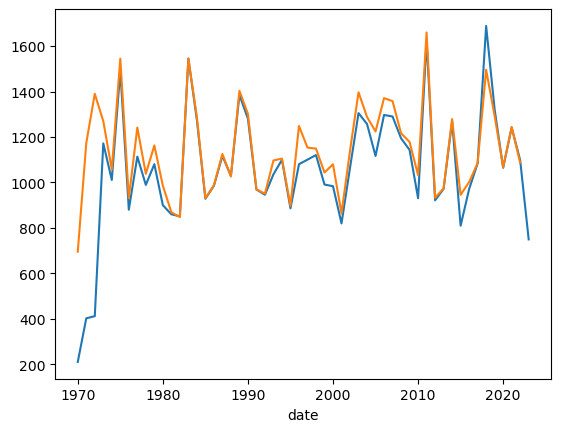

In [35]:
(nyc_daily_hourly.groupby(lambda x:x.year).sum()['LGA']*25.4).plot(label='hourly')
nyc_prcp.groupby(lambda x:x.year).sum()['USW00014732'].plot(label='NOAA')

<AxesSubplot: xlabel='date'>

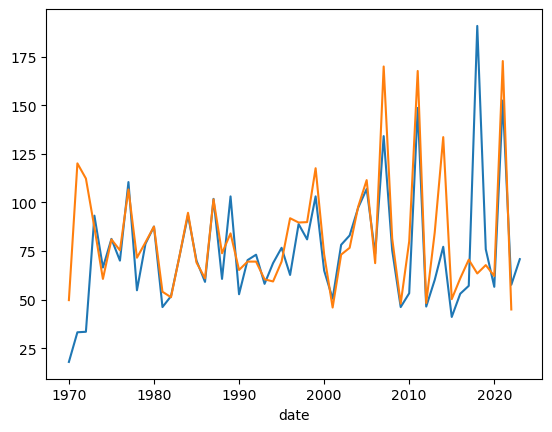

In [36]:
(nyc_daily_hourly.groupby(lambda x:x.year).max()['LGA']*25.4).plot(label='hourly')
nyc_prcp.groupby(lambda x:x.year).max()['USW00014732'].plot(label='NOAA')

<AxesSubplot: xlabel='date'>

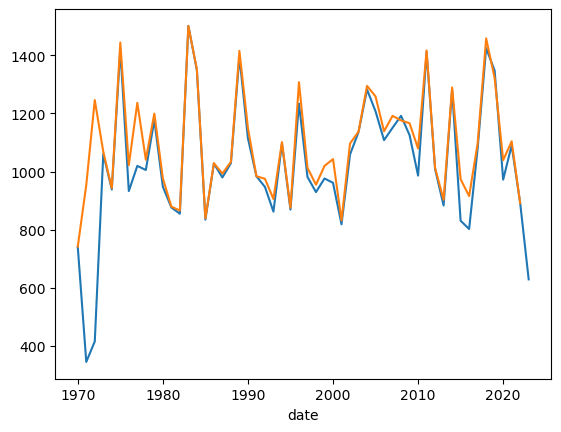

In [31]:
(nyc_daily_hourly.groupby(lambda x:x.year).sum()['JFK']*25.4).plot(label='hourly')
nyc_prcp.groupby(lambda x:x.year).sum()['USW00094789'].plot(label='NOAA')

<AxesSubplot: xlabel='date'>

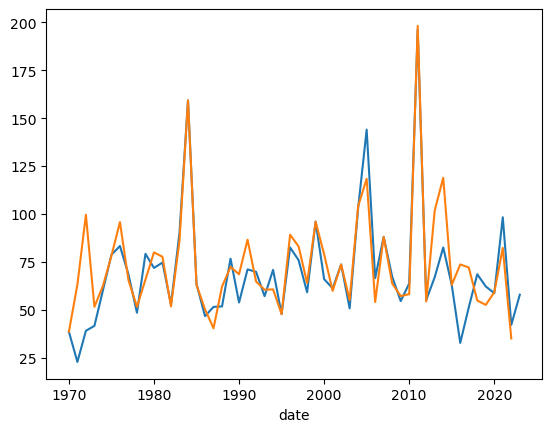

In [32]:
(nyc_daily_hourly.groupby(lambda x:x.year).max()['JFK']*25.4).plot(label='hourly')
nyc_prcp.groupby(lambda x:x.year).max()['USW00094789'].plot(label='NOAA')

<AxesSubplot: xlabel='date'>

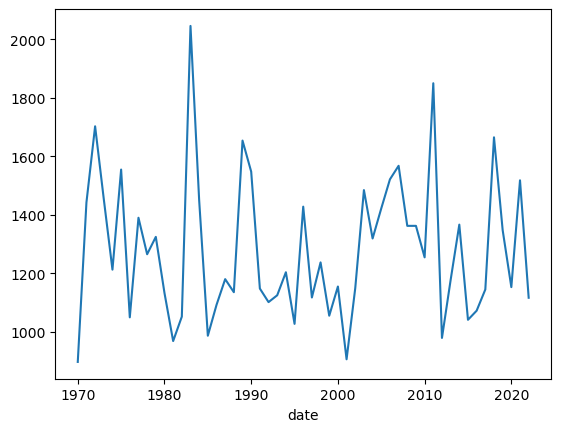

In [38]:
nyc_prcp.groupby(lambda x:x.year).sum()['USW00094728'].plot(label='NOAA')

<AxesSubplot: xlabel='date'>

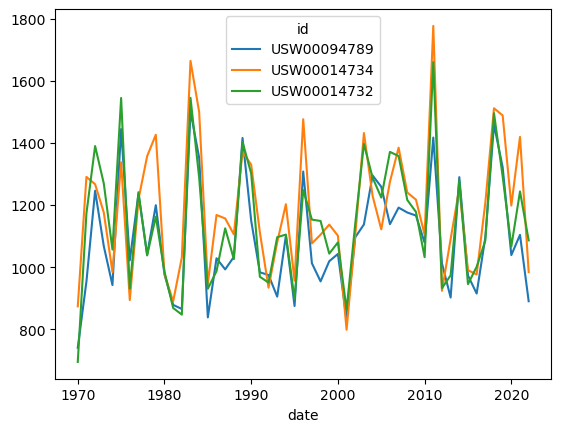

In [24]:
nyc_prcp.groupby(lambda x:x.year).sum().plot()

In [ ]:
USW00094728	NY CITY CNTRL PARK
USW00014732	LAGUARDIA AP
USW00014734	NEWARK LIBERTY INTL AP
USW00094789	JFK INTL AP
USC00281335	CANOE BROOK

In [45]:
nyc_prcp.sort_values(by='USW00094789').dropna().tail(10)

id,USW00094728,USW00094789,USW00014732,USW00014734
date,,,,
1976-08-08,23.6,95.8,46.5,4.6
1999-01-03,61.5,96.0,64.3,65.3
1972-11-08,142.2,99.6,112.3,94.2
2013-06-07,105.7,101.9,84.6,94.2
2005-10-12,108.2,103.9,111.5,80.3
2004-08-11,23.1,104.1,47.0,15.5
2005-10-14,39.1,118.4,37.6,21.1
2014-04-30,126.2,118.9,133.6,133.1
1984-06-30,78.0,159.3,94.7,49.5
